In [ ]:
pip install tensorflow_hub
pip install tensorflow
pip install Cmake
pip install sklearn
pip install --upgrade numpy scipy
pip install mkl
conda update -n base -c defaults conda
conda install -c conda-forge python-annoy
pip install torch
pip install torchvision
pip install git+https://github.com/openai/clip.git

In [5]:
import torch
import torchvision.transforms as T
import glob
from PIL import Image
from annoy import AnnoyIndex
from clip import clip
import numpy as np

import matplotlib.pyplot as plt
import torch
from PIL import Image

# 유클리디안

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Torch 라이브러리의 GPU 사용 가능 여부를 확인하고, 
# 사용 가능한 경우 device 변수를 "cuda"로 설정하고, 
# 그렇지 않은 경우 "cpu"로 설정


model, _ = clip.load("ViT-B/32", device=device)
preprocess = T.Compose([
    T.Resize((224, 224)),
    T.CenterCrop(224),
    T.ToTensor()
])
# CLIP 모델을 불러옴. ViT-B/32는 CLIP 모델의 구성 중 하나
# T.Resize(224)는 이미지의 크기를 224x224로 조정하고, 
# T.CenterCrop(224)는 이미지를 가운데를 중심으로 224x224 크기로 자름

embedding_size = 512  # CLIP 모델의 특징 벡터 크기
n_trees = 100  # annoy 인덱스의 트리 개수

annoy_index = AnnoyIndex(embedding_size, 'euclidean')
# annoy 패키지의 AnnoyIndex 클래스를 사용해 Annoy 인덱스를 초기화
# 특징 벡터의 크기와 거리 측정 방법으로 euclidean 을 인수로 전달

image_files = glob.glob(r"C:\Users\NT550009\Desktop\detail_image_aggregated/*.jpg")

# annoy_index 쌓기

In [ ]:
for image_id, image_file in enumerate(image_files):
    image = Image.open(image_file).convert("RGB")
    image = preprocess(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        image_features = model.encode_image(image)
        # model 객체를 사용하여 이미지를 인코딩하여 특징 벡터(임베딩)를 추출
        # encode_image() 함수는 CLIP 모델에서 이미지에 대한 특징 벡터를 계산하는 역할
    image_features = image_features.cpu().numpy().flatten()
    # Annoy 인덱스에 추가하기 위해 특징 벡터를 CPU 메모리로 이동시키고, 
    # NumPy 배열로 변환한 후 1차원으로 평탄화
    
    annoy_index.add_item(image_id, image_features)

annoy_index.build(n_trees)
# Annoy 인덱스 구축. 
# 트리 개수가 많을수록 인덱스의 정확도가 증가하지만, 구
# 축에 소요되는 시간도 더 많이 소요

annoy_index.save("annoy_index.ann")

In [3]:
# annoy_index 
annoy_index = AnnoyIndex(embedding_size, 'euclidean')
annoy_index.load(r"C:\Users\NT550009\Desktop\annoy_index.ann")

True

# CUDA
"cuda"는 NVIDIA의 컴퓨팅 플랫폼인 CUDA(Compute Unified Device Architecture)를 가리킵니다. CUDA는 NVIDIA GPU(그래픽 처리 장치)를 사용하여 병렬 컴퓨팅 작업을 수행하기 위한 소프트웨어 및 툴킷입니다.

PyTorch와 같은 딥러닝 프레임워크는 CUDA를 사용하여 GPU를 활용한 연산을 수행할 수 있습니다. GPU는 병렬 처리 능력이 뛰어나기 때문에 딥러닝 모델의 학습 및 추론 속도를 향상시킬 수 있습니다. "cuda"를 사용하여 딥러닝 모델을 GPU로 이동시키면 GPU를 통해 연산을 수행하므로 빠른 속도와 성능 향상을 기대할 수 있습니다.

# Query 이미지와 유사도 

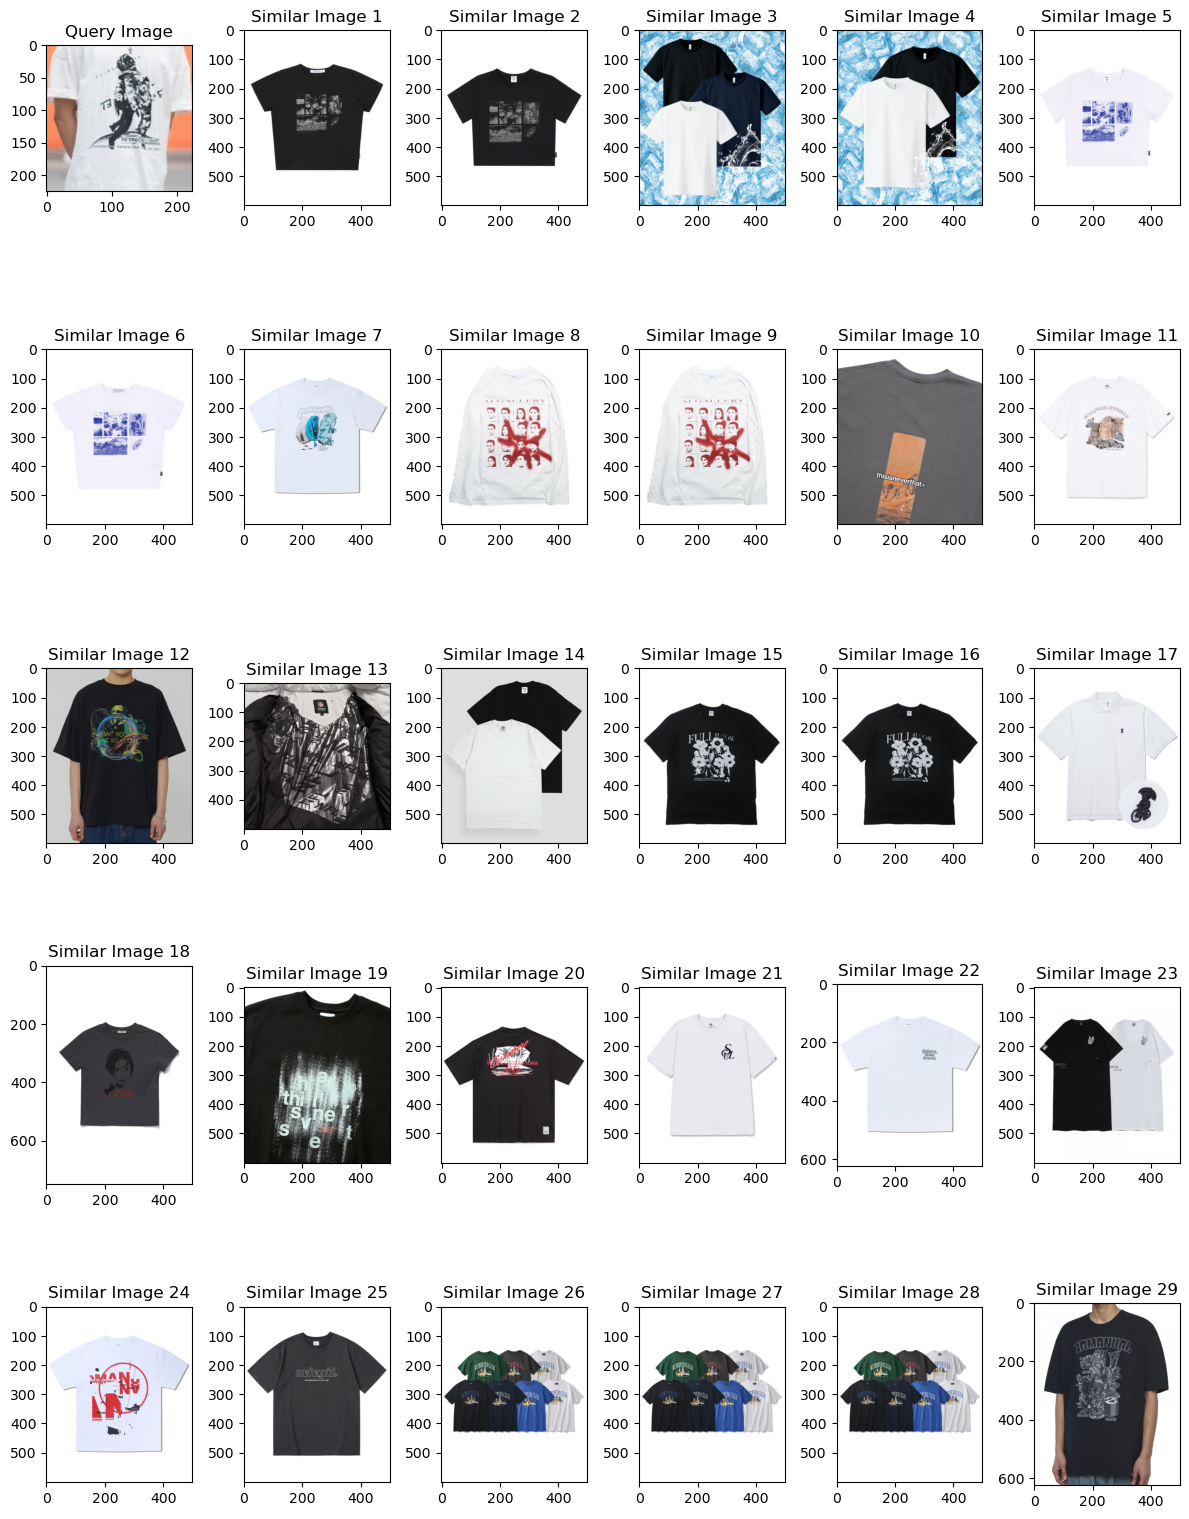

In [6]:
# 1. 쿼리 이미지 준비
query_image_path = r"C:\Users\NT550009\Desktop\recommendation\T-shirt.jpg"
query_image = Image.open(query_image_path).convert("RGB")

# 2. 쿼리 이미지 전처리하여 특징 벡터 추출
query_preprocess = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor()
])
query_image = query_preprocess(query_image).unsqueeze(0).to(device)
with torch.no_grad():
    query_features = model.encode_image(query_image)
query_features = query_features.cpu().numpy().flatten()

# 3. Annoy 인덱스에서 유사한 사진의 인덱스 검색
n_similar_images = 29
similar_image_indices = annoy_index.get_nns_by_vector(query_features, n_similar_images)

# 4. 유사한 사진들 가져오기
similar_images = [Image.open(image_files[index]).convert("RGB") for index in similar_image_indices]

# 5. 쿼리 이미지와 유사한 사진들을 plt로 출력
fig, axes = plt.subplots(5, 6, figsize=(12, 16))

axes[0, 0].imshow(query_image.squeeze().permute(1, 2, 0))
axes[0, 0].set_title("Query Image")

for i, image in enumerate(similar_images):
    row = (i + 1) // 6
    col = (i + 1) % 6
    axes[row, col].imshow(image)
    axes[row, col].set_title(f"Similar Image {i+1}")

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.tight_layout()
plt.show()